# Data Prep

In [27]:
import os
from pandas import read_csv
import pandas as pd
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
from matplotlib import pyplot as plt
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import (RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN, SMOTE, SMOTENC
from imblearn.pipeline import Pipeline
from scipy.sparse import hstack
import warnings
from sklearn.metrics import roc_curve, auc, f1_score, roc_auc_score, balanced_accuracy_score
warnings.filterwarnings("ignore")

In [28]:
data_path = '/Users/subashkhanal/Desktop/BMI633/ADNI_Genetics/Genomics/data/'

In [29]:
N = 100
#Gene ranking based on ttest
ttest = read_csv(os.path.join(data_path,'t_test_0.05_geneExpr_Unfiltered_bl.csv')).sort_values('CN_AD')
important_probes = ttest.sort_values('CN_AD'+'_c')['Gene'][0:N] #suffix _c to use the FDR corrected p values

#Quality controlled GWAS data
GWAS_data = read_csv(os.path.join(data_path,'GWAS_data_Dx_bl.csv'),na_values=["00"],low_memory=False)
GWAS_data = GWAS_data.iloc[:, 0:N+6] #Only top N snps
GWAS_data = GWAS_data.drop(columns=['Unnamed: 0'])
GWAS_data.dropna(inplace=True)

#Gene Expression Data
Gene_expr = read_csv(os.path.join(data_path,'Unfiltered_gene_expr_dx.csv'),low_memory=False)
Gene_expr = Gene_expr[['Unnamed: 0','AGE','PTGENDER','PTEDUCAT','DX_bl']+list(important_probes)]

In [30]:
lastsnp = GWAS_data.columns[-1]
lastsnp

'rs17755381'

In [31]:
common_subjects = set(GWAS_data['PTID']).intersection(set(Gene_expr['Unnamed: 0']))

In [32]:
GWAS_data_final = GWAS_data[pd.DataFrame(GWAS_data.PTID.tolist()).isin(common_subjects).any(1).values]

In [33]:
Gene_expr_final = Gene_expr[pd.DataFrame(Gene_expr['Unnamed: 0'].tolist()).isin(common_subjects).any(1).values]

In [34]:
Counter(GWAS_data_final.DIAG)

Counter({'CN': 210, 'AD': 24})

In [35]:
Counter(Gene_expr_final.DX_bl)

Counter({'CN': 210, 'AD': 24})

In [36]:
cols = Gene_expr_final.columns
Gene_expr_final.columns = ['PTID','AGE','GENDER','EDU','DIAG']+list(cols[5:])
Gene_expr_final

,PTID,AGE,GENDER,EDU,DIAG,11761978_at_ARHGEF12,11754382_a_at_SMIM5,11755705_a_at_SMIM5,11758611_s_at_TRIM10,11724079_s_at_E2F2,...,11721674_s_at_GLRX5,AFFX-DapX-5_at_AFFX-Nonspecific-GC14_at,11722181_a_at_ATP6V1C1,11747106_a_at_RREB1,11722970_a_at_CREB5,11730765_at_CD177,11741967_a_at_CDYL,11719884_s_at_KAZN,11741528_a_at_ACP1,11742801_a_at_MAP2K3
0,116_S_1249,70.8,Female,15.0,CN,4.573,7.203,7.587,7.559,9.251,...,9.832,9.965,6.100,3.281,10.055,2.685,4.860,4.284,5.958,10.105
1,037_S_4410,69.1,Female,14.0,CN,4.969,5.378,5.535,5.297,8.335,...,9.058,9.585,6.286,3.329,9.610,2.871,4.361,3.639,5.993,9.708
2,006_S_4153,79.3,Male,20.0,AD,4.805,6.094,6.355,6.496,8.940,...,9.448,10.024,5.722,2.977,9.427,3.387,3.853,3.345,5.910,10.299
3,116_S_1232,72.1,Female,14.0,CN,6.287,8.110,8.376,9.000,10.421,...,10.705,10.282,5.833,3.139,9.529,2.574,5.427,3.537,6.619,10.994
15,037_S_4308,74.0,Male,16.0,CN,4.270,5.541,5.888,6.708,8.958,...,9.834,9.968,6.127,3.192,9.773,3.866,4.951,3.501,5.995,10.113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,014_S_4401,67.5,Female,20.0,CN,3.908,7.351,7.594,7.642,9.441,...,9.454,10.006,6.849,3.292,10.848,4.372,4.699,4.844,5.894,10.702
730,137_S_0459,72.9,Male,16.0,CN,5.065,8.365,8.638,8.293,9.558,...,10.500,10.853,5.430,3.470,9.011,4.413,5.340,2.896,6.788,10.641
732,023_S_4164,72.6,Male,12.0,CN,5.631,7.049,7.388,8.292,10.198,...,10.101,10.403,6.215,2.915,9.104,3.277,5.306,3.307,6.250,10.500
734,082_S_4339,84.3,Male,17.0,CN,4.563,7.017,7.071,7.277,9.013,...,9.600,10.840,6.482,3.540,9.496,4.845,4.973,3.708,5.536,10.614


In [37]:
GWAS_data_final

,PTID,AGE,GENDER,EDU,DIAG,rs2075650,rs11253696,rs2136613,rs157580,rs6116375,...,rs17763769,rs699096,rs1467719,rs4351677,rs12205042,rs6585082,rs10833513,rs6070893,rs3785602,rs17755381
0,014_S_0520,77.7,Female,16,CN,GG,GG,TT,CC,CC,...,GA,GG,AA,GG,TC,AG,TT,TC,GG,GG
3,018_S_0055,75.5,Male,20,CN,GG,GG,TT,CC,CC,...,GA,GA,AA,GG,TC,AG,CT,TC,GG,GG
4,027_S_0118,80.4,Male,20,CN,GG,GG,TT,CC,CT,...,GG,GG,AA,GG,CC,AA,CT,CC,GT,GG
9,098_S_0171,78.3,Female,17,CN,GG,GG,TT,CC,CT,...,GG,AA,AG,GT,TT,GG,CT,TC,GG,GA
13,011_S_0023,71.7,Male,14,CN,GG,GG,TT,CC,CC,...,GA,GA,AA,GG,TT,AG,CC,TT,TT,GG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539,018_S_4400,71.1,Male,20,CN,AA,GT,TC,CC,CT,...,AA,GA,AG,GT,TC,GG,CC,TC,GG,GA
541,041_S_4014,80.7,Male,16,CN,GG,GG,TT,CC,CT,...,GA,GG,AA,GG,TC,AG,CC,TC,GG,GG
542,094_S_4282,89.6,Male,12,AD,GG,GG,TT,CC,TT,...,GA,GG,AA,GG,TC,AG,CT,TC,GG,GA
543,033_S_4179,83.0,Male,20,CN,GG,GG,TT,CC,CC,...,GG,GA,AG,GT,TC,AA,CC,TC,TT,GA


In [38]:
GWAS_GeneExpr_df = pd.merge(GWAS_data_final, Gene_expr_final,  how='left', on=['PTID','AGE','GENDER','EDU','DIAG'])

In [39]:
GWAS_GeneExpr_df

,PTID,AGE,GENDER,EDU,DIAG,rs2075650,rs11253696,rs2136613,rs157580,rs6116375,...,11721674_s_at_GLRX5,AFFX-DapX-5_at_AFFX-Nonspecific-GC14_at,11722181_a_at_ATP6V1C1,11747106_a_at_RREB1,11722970_a_at_CREB5,11730765_at_CD177,11741967_a_at_CDYL,11719884_s_at_KAZN,11741528_a_at_ACP1,11742801_a_at_MAP2K3
0,014_S_0520,77.7,Female,16,CN,GG,GG,TT,CC,CC,...,9.871,10.176,5.191,3.540,8.538,2.485,5.077,2.674,6.290,10.536
1,018_S_0055,75.5,Male,20,CN,GG,GG,TT,CC,CC,...,9.944,10.523,6.583,2.972,10.479,6.686,4.785,4.558,5.811,10.613
2,027_S_0118,80.4,Male,20,CN,GG,GG,TT,CC,CT,...,9.393,10.382,6.507,3.385,9.621,3.810,5.149,2.493,5.991,10.088
3,098_S_0171,78.3,Female,17,CN,GG,GG,TT,CC,CT,...,9.573,11.014,5.292,3.731,9.399,2.754,5.064,3.408,6.207,10.225
4,011_S_0023,71.7,Male,14,CN,GG,GG,TT,CC,CC,...,11.322,10.843,5.077,3.411,8.102,2.523,5.985,2.840,6.854,11.617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,018_S_4400,71.1,Male,20,CN,AA,GT,TC,CC,CT,...,9.139,10.191,5.922,3.298,8.769,3.072,5.312,3.610,5.895,10.429
230,041_S_4014,80.7,Male,16,CN,GG,GG,TT,CC,CT,...,9.786,10.949,6.075,3.327,8.990,2.547,5.556,2.801,6.631,10.307
231,094_S_4282,89.6,Male,12,AD,GG,GG,TT,CC,TT,...,9.734,10.503,5.373,3.213,9.125,2.851,4.841,3.564,6.244,10.545
232,033_S_4179,83.0,Male,20,CN,GG,GG,TT,CC,CC,...,10.077,10.888,6.482,3.019,9.690,3.110,4.949,4.459,5.678,10.190


In [40]:
Counter(GWAS_GeneExpr_df.DIAG)

Counter({'CN': 210, 'AD': 24})

# Classification

In [49]:
# https://machinelearningmastery.com/feature-selection-with-categorical-data/

# load the dataset
def load_dataset(df,df_type):
    # load the dataset as a pandas DataFrame
    data = df
    y = data.DIAG.values  
    if df_type == 'GWAS_GeneExpr':
        numeric_df = data[['AGE','EDU']+list(important_probes)]
#         scaler = StandardScaler()
#         scaler.fit(numeric_df)
#         numeric_df = scaler.transform(numeric_df)
        categorical_df = data[list(set(data.columns)-set(numeric_df.columns)-set(['DIAG']))].astype(str)

    if df_type == 'GWAS':
        numeric_df = data[['AGE','EDU']]
#         scaler = StandardScaler()
#         scaler.fit(numeric_df)
#         numeric_df = scaler.transform(numeric_df)
        categorical_df = data[list(set(data.columns)-set(numeric_df.columns)-set(['DIAG']))].astype(str)
        
    if df_type == 'GeneExpr':
        numeric_df = data[['AGE','EDU']+list(important_probes)]
#         scaler = StandardScaler()
#         scaler.fit(numeric_df)
#         numeric_df = scaler.transform(numeric_df)
        categorical_df = data[list(set(data.columns)-set(numeric_df.columns)-set(['DIAG']))].astype(str)
        
    return np.array(numeric_df), categorical_df, y
 
# prepare input data
def prepare_inputs(X):
    oe = OneHotEncoder()
    oe.fit(X)
    X_enc = oe.transform(X)
    return X_enc
 
# prepare target
def prepare_targets(y):
    le = LabelEncoder()
    le.fit(y)
    y = le.transform(y)
    return y

def overall_exp(df,df_type):
    
    # load the dataset
    numeric_df, categorical_df, y = load_dataset(df,df_type)
    X_enc = prepare_inputs(categorical_df)
    y_enc = prepare_targets(y)

    X_cat_numeric = hstack((X_enc,numeric_df[:,:]))

    ######################################################################

    #                            GRID SEARCH

    ######################################################################

    X, y = X_cat_numeric, y_enc
    # define model
    model = GradientBoostingClassifier(random_state=1)
    # define evaluation
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)
    # define search space
    space = dict()
    space['n_estimators'] = [50,100,250,500,1000,2000,2500,3000,3500,4000]

    scoring = {'AUC': 'roc_auc', 'Balanced Accuracy':'balanced_accuracy'}
    # define search
    search = GridSearchCV(model, space,cv=cv,scoring=scoring, refit='Balanced Accuracy', return_train_score=True)
    # execute search
    result = search.fit(X, y)
    # summarize result
    print('Best Score: %s' % result.best_score_)
    print('Best Hyperparameters: %s' % result.best_params_)

    results = search.cv_results_

    return results


In [53]:

#https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py

# Author: Raghav RV <rvraghav93@gmail.com>
# License: BSD

def auc_plot(results):

    print(__doc__)
    
    from matplotlib import pyplot as plt
    plt.figure(figsize=(13, 13))
    plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
              fontsize=16)

    plt.xlabel("param_n_estimators")
    plt.ylabel("Score")

    ax = plt.gca()
    ax.set_xlim(50, 4002)
    ax.set_ylim(0.50, 1)

    # Get the regular numpy array from the MaskedArray
    X_axis = np.array(results['param_n_estimators'].data, dtype=float)
    scoring = {'AUC': 'roc_auc', 'Balanced Accuracy':'balanced_accuracy'}
    
    for scorer, color in zip(sorted(scoring), ['g', 'k']):
        for sample, style in (('train', '--'), ('test', '-')):
            sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
            sample_score_std = results['std_%s_%s' % (sample, scorer)]
            ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                            sample_score_mean + sample_score_std,
                            alpha=0.1 if sample == 'test' else 0, color=color)
            ax.plot(X_axis, sample_score_mean, style, color=color,
                    alpha=1 if sample == 'test' else 0.7,
                    label="%s (%s)" % (scorer, sample))

        best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
        best_score = results['mean_test_%s' % scorer][best_index]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax.plot([X_axis[best_index], ] * 2, [0, best_score],
                linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

        # Annotate the best score for that scorer
        ax.annotate("%0.2f" % best_score,
                    (X_axis[best_index], best_score + 0.005))

    plt.legend(loc="best")
    plt.grid(False)
    plt.show()



Best Score: 0.6170634920634921
Best Hyperparameters: {'n_estimators': 3000}
Automatically created module for IPython interactive environment


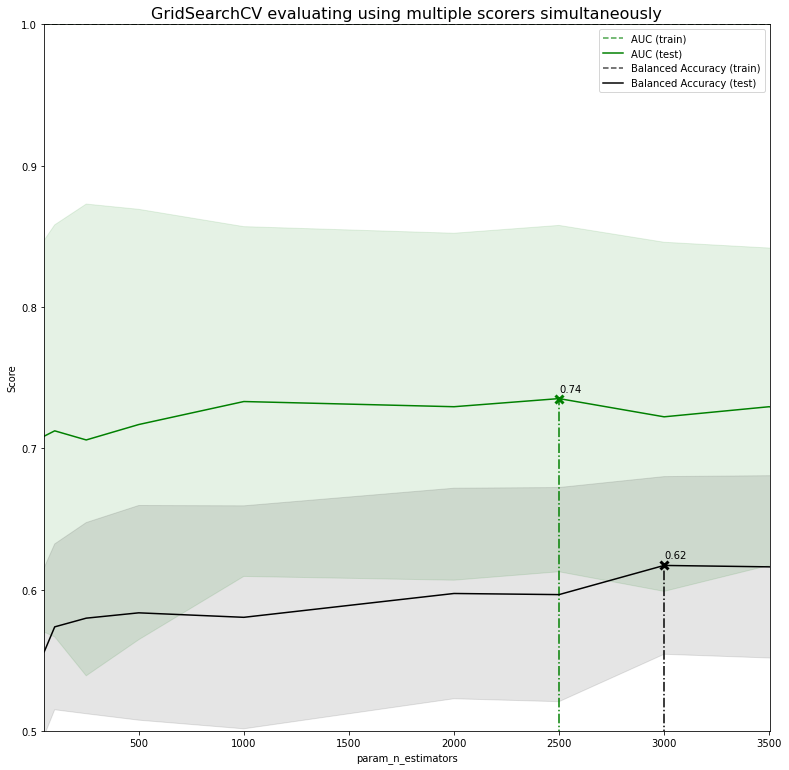

In [51]:
df = Gene_expr_final #Options: ['GWAS_data_final','Gene_expr_final','GWAS_GeneExpr_df']
df_type = 'GeneExpr' # Options: ['GWAS_GeneExpr','GWAS','GeneExpr']
results = overall_exp(df,df_type)
auc_plot(results)

Automatically created module for IPython interactive environment


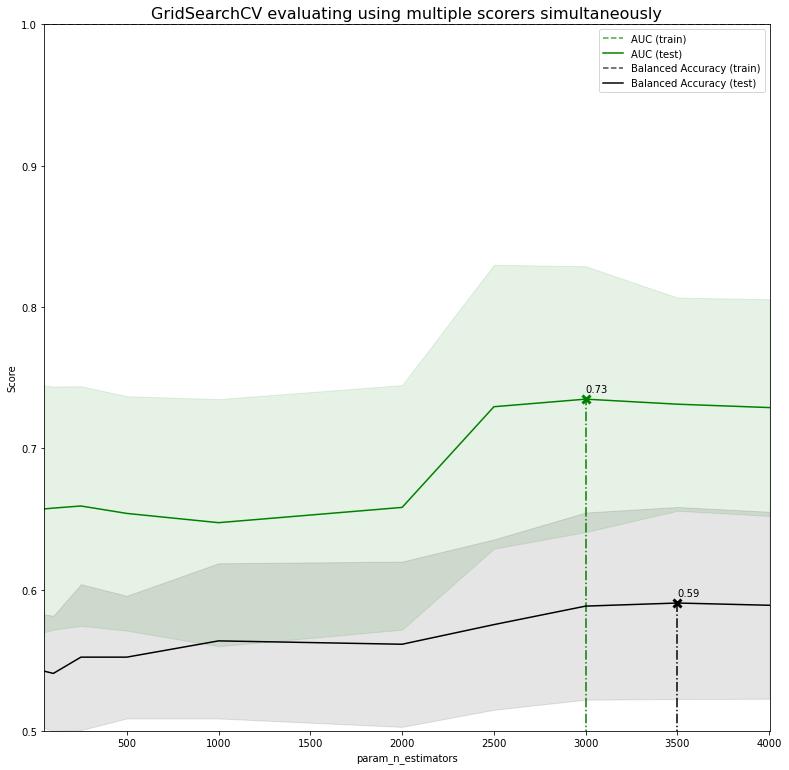

In [54]:
df = GWAS_data_final #Options: ['GWAS_data_final','Gene_expr_final','GWAS_GeneExpr_df']
df_type = 'GWAS' # Options: ['GWAS_GeneExpr','GWAS','GeneExpr']
results = overall_exp(df,df_type)
auc_plot(results)

Best Score: 0.592857142857143
Best Hyperparameters: {'n_estimators': 1000}
Automatically created module for IPython interactive environment


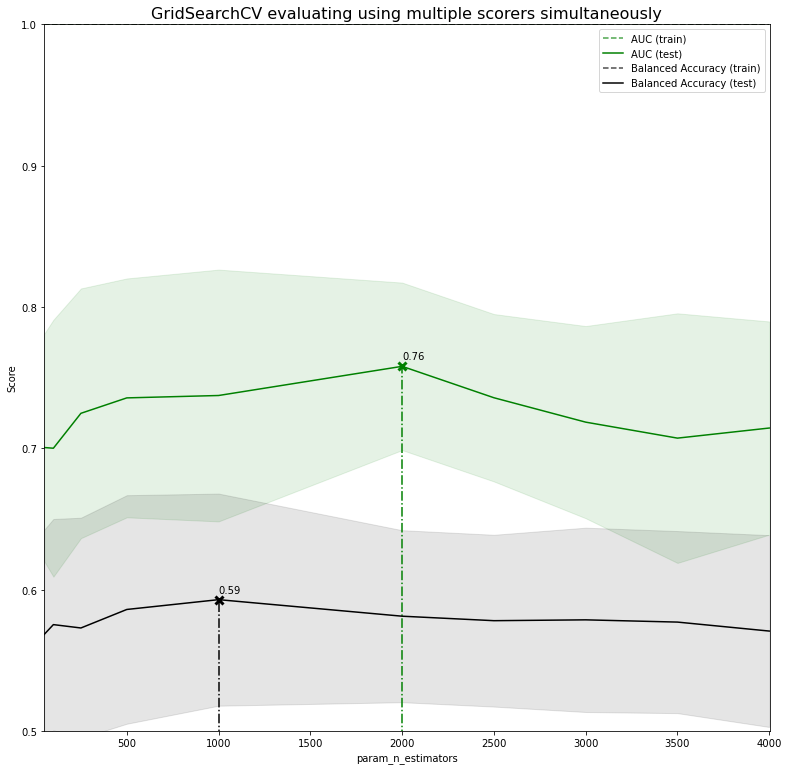

In [55]:
df = GWAS_GeneExpr_df #Options: ['GWAS_data_final','Gene_expr_final','GWAS_GeneExpr_df']
df_type = 'GWAS_GeneExpr' # Options: ['GWAS_GeneExpr','GWAS','GeneExpr']
results = overall_exp(df,df_type)
auc_plot(results)

# Let's Add SMOTENC and see if it helps

In [57]:
df = GWAS_GeneExpr_df
y = df.DIAG
df = df.drop(columns=['PTID','DIAG'])
df

,AGE,GENDER,EDU,rs2075650,rs11253696,rs2136613,rs157580,rs6116375,rs6501384,rs6436329,...,11721674_s_at_GLRX5,AFFX-DapX-5_at_AFFX-Nonspecific-GC14_at,11722181_a_at_ATP6V1C1,11747106_a_at_RREB1,11722970_a_at_CREB5,11730765_at_CD177,11741967_a_at_CDYL,11719884_s_at_KAZN,11741528_a_at_ACP1,11742801_a_at_MAP2K3
0,77.7,Female,16,GG,GG,TT,CC,CC,GA,GG,...,9.871,10.176,5.191,3.540,8.538,2.485,5.077,2.674,6.290,10.536
1,75.5,Male,20,GG,GG,TT,CC,CC,GG,GG,...,9.944,10.523,6.583,2.972,10.479,6.686,4.785,4.558,5.811,10.613
2,80.4,Male,20,GG,GG,TT,CC,CT,GA,GG,...,9.393,10.382,6.507,3.385,9.621,3.810,5.149,2.493,5.991,10.088
3,78.3,Female,17,GG,GG,TT,CC,CT,GG,GT,...,9.573,11.014,5.292,3.731,9.399,2.754,5.064,3.408,6.207,10.225
4,71.7,Male,14,GG,GG,TT,CC,CC,GA,GG,...,11.322,10.843,5.077,3.411,8.102,2.523,5.985,2.840,6.854,11.617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,71.1,Male,20,AA,GT,TC,CC,CT,GG,TT,...,9.139,10.191,5.922,3.298,8.769,3.072,5.312,3.610,5.895,10.429
230,80.7,Male,16,GG,GG,TT,CC,CT,GA,GG,...,9.786,10.949,6.075,3.327,8.990,2.547,5.556,2.801,6.631,10.307
231,89.6,Male,12,GG,GG,TT,CC,TT,AA,GG,...,9.734,10.503,5.373,3.213,9.125,2.851,4.841,3.564,6.244,10.545
232,83.0,Male,20,GG,GG,TT,CC,CC,GG,GG,...,10.077,10.888,6.482,3.019,9.690,3.110,4.949,4.459,5.678,10.190


In [64]:
num_col_index = [0,2] + list(range(3+N,3+N+N))
cat_col_index = [1] + list(range(3,3+N))
num_col = list(df.iloc[:,num_col_index].columns)
cat_col = list(df.iloc[:,cat_col_index].columns)
df[num_col] = df[num_col].fillna(value=df[num_col].mean())
df.columns[df.isna().any()].tolist()

[]

In [62]:
import os
def train_scaler(data,num_col_index):
    scaled_features = data.copy()
    features = scaled_features.iloc[:,num_col_index]
    scaler = StandardScaler().fit(features.values)
    features = scaler.transform(features.values)
    scaled_features.iloc[:,num_col_index] = features
    return scaler, scaled_features
    
def test_scaler(scaler,data,num_col_index):
    scaled_features = data.copy()
    features = scaled_features.iloc[:,num_col_index]
    features = scaler.transform(features.values)
    scaled_features.iloc[:,num_col_index] = features
    
    return scaled_features

# prepare categorical input data
def prepare_cat(X):
    oe = OneHotEncoder()
    oe.fit(X)
    X_enc = oe.transform(X)
    return X_enc
 
# prepare target
def prepare_targets(y):
    le = LabelEncoder()
    le.fit(y)
    y = le.transform(y)
    return y

def data_prep(X_train,y_train,X_test,y_test,num_col_index, cat_col_index): 
    
    #Oversample the minority class 
    smt = SMOTENC(categorical_features =cat_col_index, 
                random_state=123,
                k_neighbors=10,
                sampling_strategy=.6
                     )
    X_trainres,y_trainres = smt.fit_resample(X_train,y_train) #Oversampled training set
    
    # Standard Scaling of numeric variable
    scaler, X_trainres_scaled = train_scaler(X_trainres,num_col_index)
    X_test_scaled = test_scaler(scaler,X_test,num_col_index)
    
    # One hot encoding of categorical variable
    combined_data = pd.concat([X_trainres_scaled.iloc[:,cat_col_index], X_test_scaled.iloc[:,cat_col_index]], ignore_index=True)
    combined_data_cat = prepare_cat(combined_data)
    X_train_cat = combined_data_cat[0:len(X_trainres_scaled),:]
    X_test_cat = combined_data_cat[len(X_trainres_scaled):,:]

    #Concatenation of numerical and categorical inputs
    X_train_final = hstack((X_train_cat,X_trainres_scaled.iloc[:,num_col_index]))
    X_test_final = hstack((X_test_cat,X_test_scaled.iloc[:,num_col_index]))
    
    
    # Binarization of target label
    y_train_final = prepare_targets(y_trainres)
    y_test_final = prepare_targets(y_test)
    
   
    return X_train_final,y_train_final,X_test_final,y_test_final

def classifier(name,n_estimators=100):
    if name == 'RandomForestClassifier':
        return RandomForestClassifier(n_estimators=n_estimators,criterion='gini',class_weight='balanced',random_state=1)
    
    if name == 'GradientBoosting':
        return GradientBoostingClassifier(n_estimators=n_estimators,random_state=1)
    
    else:
        raise NotImplementedError("This classifier is not implemented yet. Please choose from [RandomForest, GradientBoosting]")

        
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
X = df
acc = []
f1 = []
auc = []
imp = []
for train, test in cv.split(df, y):
    X_train = X.iloc[train]
    y_train = y[train]
    
    X_test = X.iloc[test]
    y_test = y[test]

    X_train_final,y_train_final,X_test_final,y_test_final = data_prep(X_train,y_train,X_test,y_test,num_col_index, cat_col_index)
    n_estimators = 1000
    model = classifier('GradientBoosting', n_estimators)
    probas_ = model.fit(X_train_final, y_train_final).predict_proba(X_test_final)
    y_pred = model.predict(X_test_final)
    acc.append(balanced_accuracy_score(y_test_final, y_pred))
    f1.append(f1_score(y_test_final, y_pred, average='macro'))
    auc.append(roc_auc_score(y_test_final, probas_[:, 1]))	    	
    #print(model.feature_importances_.shape)
    exit(1)
    imp.append(model.feature_importances_)
print(sum(acc)/len(acc))
print(sum(auc)/len(auc))

0.5807142857142855
0.887


# Conclusion

Even inclusion of SMOTENC techinque did not improve the performance, maybe the Integration is bad idea afterall

Or the sample size is too small to do this experiment